## Plotting

In [30]:
# %matplotlib widget

import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase


# Plot settings
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['legend.loc'] = 'lower center'
plt.rcParams['legend.frameon'] = False
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titley'] = 1.03
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2  # setting the x-axis tick width globally
plt.rcParams['ytick.major.width'] = 2 # setting the y-axis tick width globally
# Set fig size
plt.rcParams['figure.figsize'] = (12, 8)

In [62]:
scenario_folder = r'C:\Users\wangy\OneDrive\ETHY2FW\IDP_Personal\CEA\2050 w3'
zone_gdf = gpd.read_file(scenario_folder + r'\inputs\building-geometry\zone.shp')
store_folder = './pareto_no_wood/pareto_no_wood_test'
zone_gdf.index = zone_gdf['Name']

# Create a new df using only the columns we need
zone_df = pd.DataFrame()
zone_df['Name'] = zone_gdf['Name']
zone_df.set_index('Name', inplace=True)

# Read typology file 
typology_df = gpd.read_file(scenario_folder + r'\inputs\building-properties\typology.dbf', ignore_geometry=True).set_index('Name')
zone_df = pd.concat([zone_df, typology_df['YEAR']], axis=1)
zone_gdf['area'] = zone_gdf['geometry'].area
zone_df = pd.concat([zone_df, zone_gdf['area'], zone_gdf['floors_ag']], axis=1)

# read the csv file containing if the building is inside district area
district_df = pd.read_csv(scenario_folder + r'\inputs\is_disheat.csv', index_col=0)
zone_df = zone_df.merge(district_df, left_index=True, right_index=True)

# Read the csv file containing if building is rebuilt
rebuild_df = pd.read_csv(scenario_folder + r'\inputs\Rebuild.csv', index_col=0)

zone_df = zone_df.merge(rebuild_df, left_index=True, right_index=True, how='left').fillna(0)

# Read the csv file containing if the building is renovated
renovate_df = pd.read_csv(scenario_folder + r'\inputs\Renovation.csv', index_col=0)

zone_df = zone_df.merge(renovate_df, left_index=True, right_index=True, how='left').fillna(0)

# Read dbf file containing current building systems
current_heating_system_df = gpd.read_file(scenario_folder + r'\inputs\building-properties\supply_systems.dbf', ignore_geometry=True).set_index('Name')[['type_hs']]
zone_df = zone_df.merge(current_heating_system_df, left_index=True, right_index=True, how='left')

# Add indicating columns to guide adjusting AttrDict based on building's status
zone_df['is_disheat'] = zone_df['DisHeat'].astype(bool)
zone_df['is_rebuilt'] = zone_df['Rebuild'].astype(bool)
zone_df['is_renovated'] = zone_df['Renovation'].astype(bool)
zone_df['is_new'] = ~zone_df['is_rebuilt'] & ~zone_df['is_renovated']
zone_df['already_GSHP'] = zone_df['type_hs'] == 'SUPPLY_HEATING_AS6'
zone_df['already_ASHP'] = zone_df['type_hs'] == 'SUPPLY_HEATING_AS7'
zone_df['no_heat'] = zone_df['type_hs'] == 'SUPPLY_HEATING_AS0'

# Get all dbfs from the following subfolder
dbf_folder = scenario_folder + r"\inputs\building-properties"
dbf_files = os.listdir(dbf_folder)
for file in dbf_files:
    if file.endswith(".dbf"):
        dbf_path = dbf_folder + "\\" + file
        df = gpd.read_file(dbf_path, ignore_geometry=True).set_index('Name')
        df.columns = [file[:-4] + "_" + col for col in df.columns]
        zone_df = pd.concat([zone_df, df], axis=1)



In [69]:
# read global pareto front csv as a multiindex dataframe
ehub_folder = r'C:\Users\wangy\OneDrive\ETHY2FW\IDP_Personal\CEA\2050 w3\outputs\data\optimization\calliope_energy_hub\backup_1009_n30'
global_path = os.path.join(ehub_folder, 'global_pareto.csv')
global_pareto_df = pd.read_csv(global_path, index_col=[0, 1])
# first index is the name of building, second index is the index of epsilon cuts
# get the first level index
buildings = global_pareto_df.index.get_level_values(0).unique()
# read building csvs in the same folder
building_dfs = {}
for building in buildings:
    building_path = os.path.join(ehub_folder, f'{building}_pareto.csv')
    building_dfs[building] = pd.read_csv(building_path, index_col=[0, 1])

# find the min and max year of the buildings that are in buildings list
year_min = zone_df.loc[buildings, 'YEAR'].min()
year_max = zone_df.loc[buildings, 'YEAR'].max()
year_norm = mcolors.Normalize(vmin=year_min, vmax=year_max)
colormap = plt.get_cmap('viridis') # type: ignore

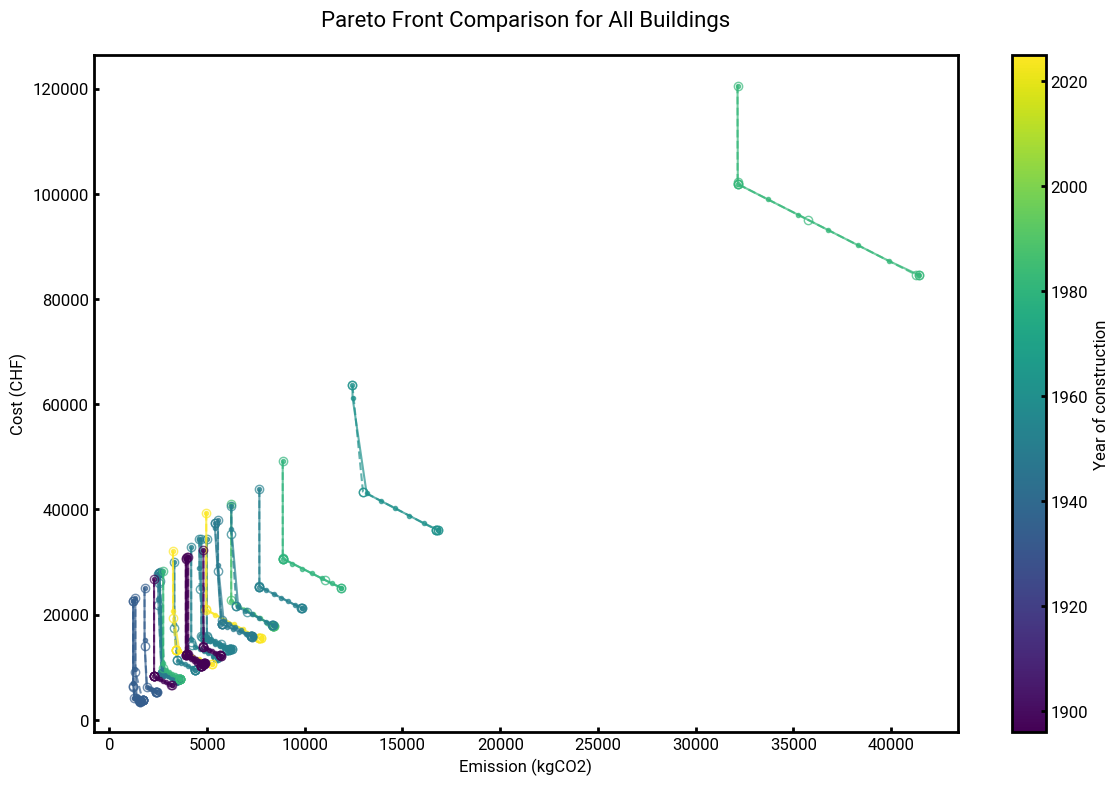

In [70]:
 # high resolution plot
fig, ax = plt.subplots()

# Define colors for each building
colors = plt.cm.tab10(np.linspace(0, 1, len(buildings)))

for color, building in zip(colors, buildings):
    building_color = colormap(year_norm(zone_df.loc[building]['YEAR']))
    local_df = building_dfs[building]
    global_df = global_pareto_df.loc[building]
    
    # Plot local pareto front
    ax.plot(local_df['emission'], local_df['cost'], label=f'{building} Local', color=building_color, marker='.', alpha=0.7)
    
    # Plot global pareto front
    ax.plot(global_df['emission'], global_df['cost'], label=f'{building} Global', color=building_color, linestyle='--', marker='o', markerfacecolor='none', alpha=0.7)

ax.set_xlabel('Emission (kgCO2)')
ax.set_ylabel('Cost (CHF)')
ax.set_title('Pareto Front Comparison for All Buildings')
# ax.legend(loc='best')
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=year_norm), ax=ax, orientation='vertical') # type: ignore
cbar.set_label('Year of construction')
fig.tight_layout()
plt.show()


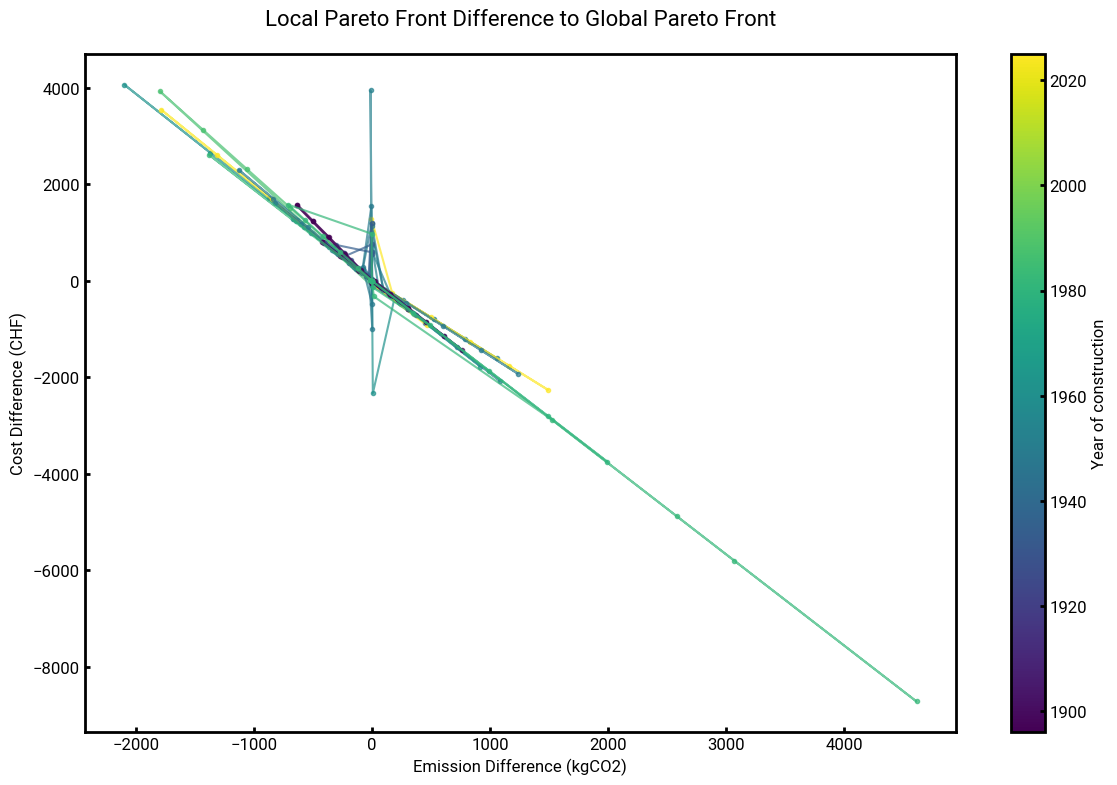

In [71]:
# just like global difference, calculate the local difference and plot it
fig, ax = plt.subplots()
for (color, building) in zip(colors, buildings):
    building_color = colormap(year_norm(zone_df.loc[building]['YEAR']))
    local_df = building_dfs[building]
    global_df = global_pareto_df.loc[building]
    ax.plot(local_df['emission']-global_df['emission'], local_df['cost']-global_df['cost'], label=building, color=building_color, marker='.', alpha=0.7)
ax.set_xlabel('Emission Difference (kgCO2)')
ax.set_ylabel('Cost Difference (CHF)')
ax.set_title('Local Pareto Front Difference to Global Pareto Front')
# ax.legend(loc='best')

cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=year_norm), ax=ax, orientation='vertical') # type: ignore
cbar.set_label('Year of construction')
fig.tight_layout()
plt.show()


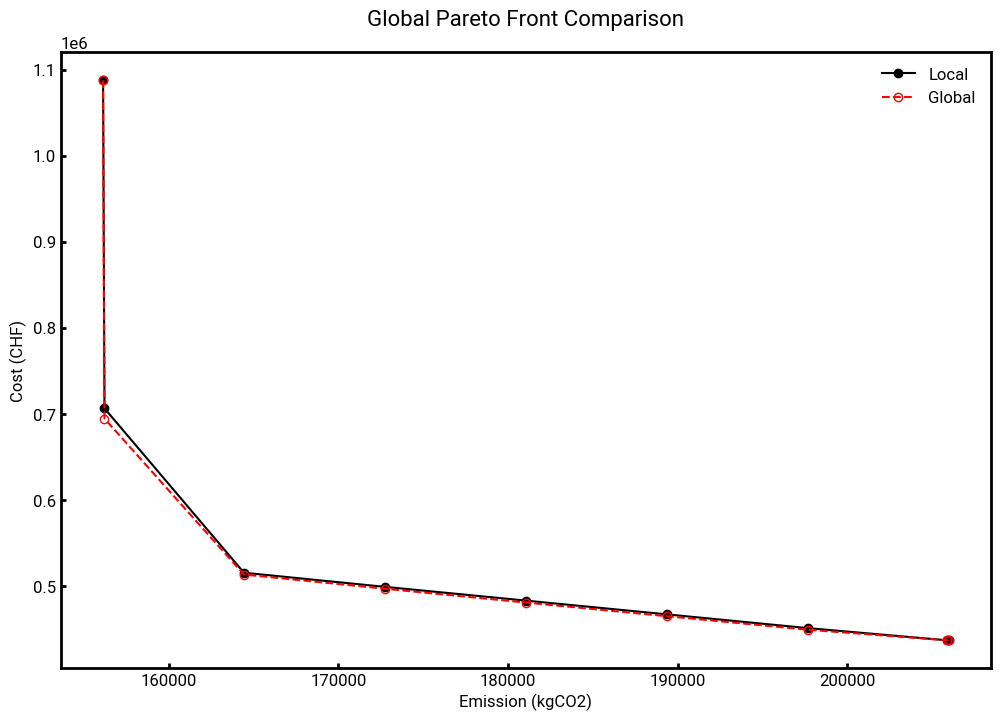

In [72]:

# then, in the global df, append at the bottom one more 1st level index called "global" and sum up all the values from other buildings
# then plot the global pareto front with the global sum
global_sum_df = global_pareto_df.groupby(level=1).sum()
local_sum_df = pd.concat(building_dfs.values()).groupby(level=1).sum()
fig, ax = plt.subplots()
ax.plot(local_sum_df['emission'], local_sum_df['cost'], label='Local', color='black', marker='o')
ax.plot(global_sum_df['emission'], global_sum_df['cost'], label='Global', color='red', linestyle='--', marker='o', markerfacecolor='none')
ax.set_xlabel('Emission (kgCO2)')
ax.set_ylabel('Cost (CHF)')
ax.set_title('Global Pareto Front Comparison')
# add legend with best position
ax.legend(loc='best')
plt.show()

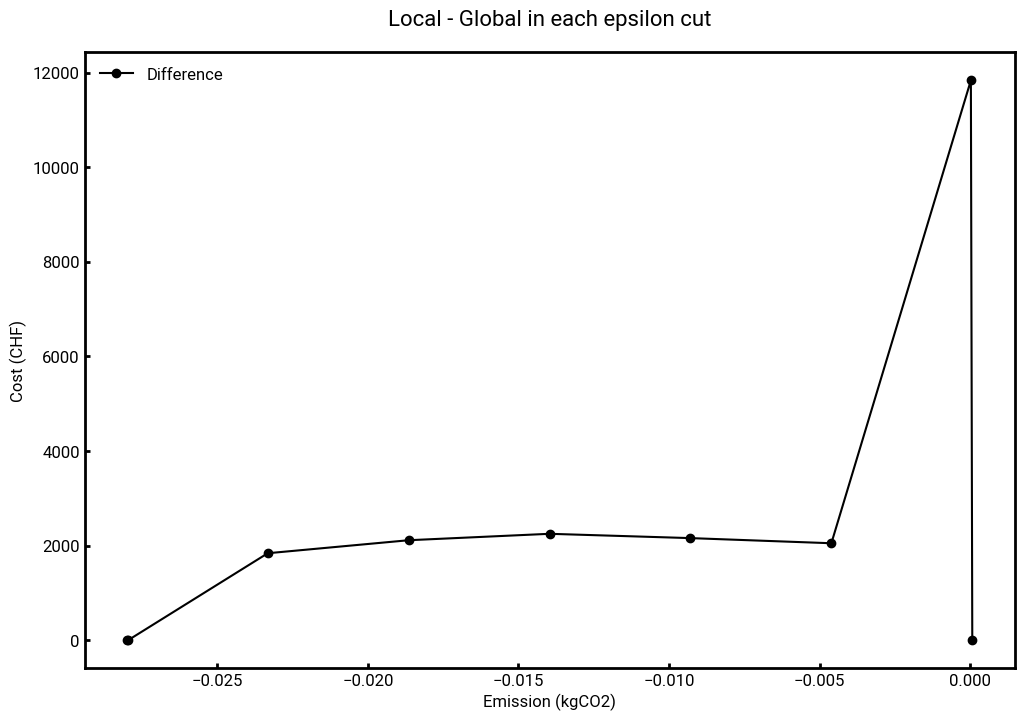

In [73]:
# then, plot the difference between the global sum and the local sum
fig, ax = plt.subplots()
ax.plot(local_sum_df['emission'] - global_sum_df['emission'], local_sum_df['cost'] - global_sum_df['cost'], label='Difference', color='black', marker='o')

ax.set_xlabel('Emission (kgCO2)')
ax.set_ylabel('Cost (CHF)')
ax.set_title('Local - Global in each epsilon cut')
# add legend with best position
ax.legend(loc='best')
plt.show()

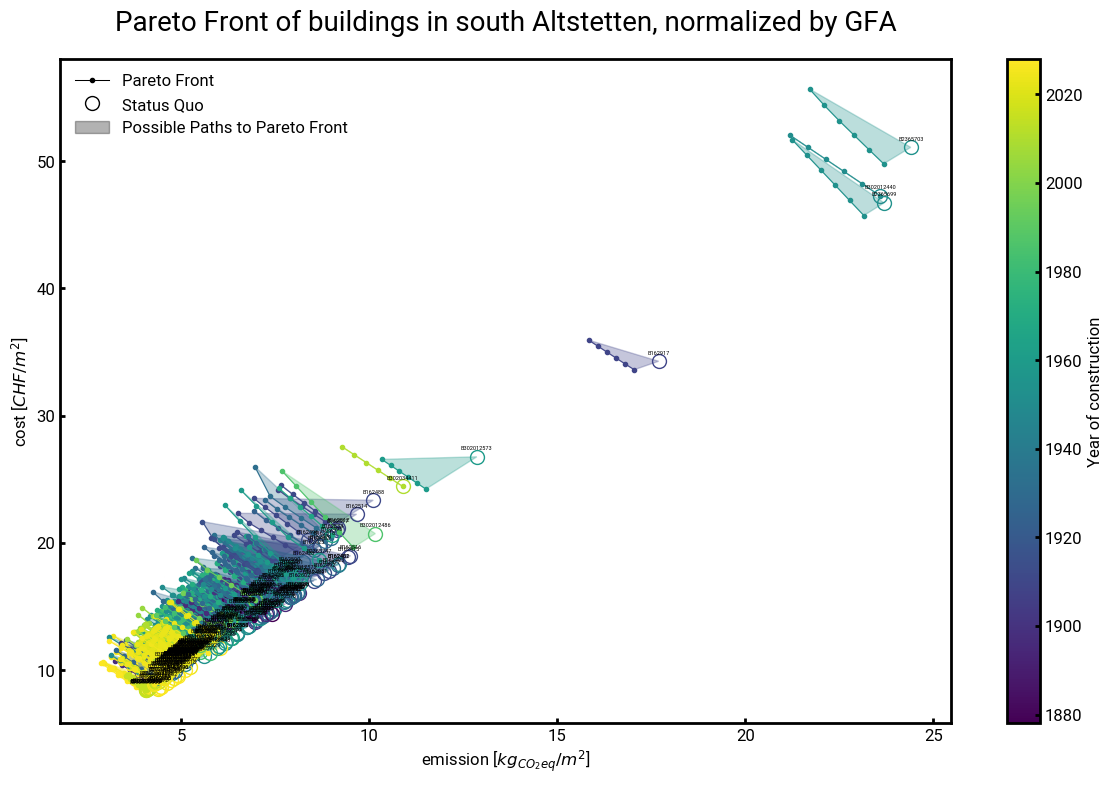

In [6]:
# Calculate the coefficient of variation of each technology choice for each building and store them in a dataframe; 
# in the end plot a bar chart with error bars for each technology in this dataframe.
# The dataframe should have columns as technology names, and rows as building names
# First define the dataframe column from one of the files in the folder;
# then iterate through the rest of the files and add the data to the dataframe
year_min = zone_df['YEAR'].min()
year_max = zone_df['YEAR'].max()
year_norm = mcolors.Normalize(vmin=year_min, vmax=year_max)
colormap = plt.get_cmap('viridis') # type: ignore
ls_csv = [csv for csv in os.listdir(store_folder) if csv.endswith('.csv')]
fig1, ax1 = plt.subplots()

# Initialize dataframe
df_tech_cap = pd.DataFrame()
i = 0
for idx, csv in enumerate(ls_csv):
    if idx == 0:
        df_example = pd.read_csv(store_folder + '/' + csv, index_col=0, nrows=1)
        # add the first level index to be building name
        df_example.index = pd.MultiIndex.from_tuples([(csv, i) for i in df_example.index], names=['building', 'epsilon'])
        df_tech_cap = pd.DataFrame(columns=df_example.columns, index=df_example.index)
        df_tech_cap = df_tech_cap.dropna(how='all')

    building_sizing = pd.read_csv(store_folder + '/' + csv, index_col=0).fillna(0)
    # # calculate the coefficient of variation for each technology
    # df_tech_cap.loc[csv[:-10]] = building_sizing.std() / building_sizing.mean()
    building_name = csv[:-11]
    if zone_df.loc[building_name, 'no_heat']:
        continue
    
    # plot once every 10 buildings
    # i += 1
    # if i % 10 == 0:
    #     pass
    # else:
    #     continue

    # # if wood_boiler is 2000 at emission optimal (the first row), then it's oversized, change it to the DHW demand
    # if building_sizing.loc[0, 'wood_boiler'] == 2000:
    #     building_sizing.loc[0, 'wood_boiler'] = building_sizing.loc[4, 'demand_hot_water']
    #     building_sizing.loc[0, 'DHDC_small_heat'] = 0
    #     building_sizing.loc[0, 'DHDC_medium_heat'] = 0
    #     building_sizing.loc[0, 'DHDC_large_heat'] = 0

    area_per_floor = pd.to_numeric(zone_df.loc[building_name, 'area'])
    n_floor = pd.to_numeric(zone_df.loc[building_name, 'floors_ag'])
    if pd.isna(area_per_floor) or pd.isna(n_floor): # check if the area_per_floor or n_floor is NaN
        raise ValueError(f"Invalid numeric values for building '{building_name}'")
    building_area = area_per_floor * n_floor
    building_sizing_per_m2 = building_sizing / building_area
    # add the first level index to be building name
    # index=999 means that the line records the building's current status
    building_sizing_per_m2.index = pd.MultiIndex.from_product([[building_name], building_sizing_per_m2.index], names=['building', 'epsilon'])

    # add the building_sizing_per_m2 to df_tech_cap to the bottom, but keep the multiindex
    df_tech_cap = pd.concat([df_tech_cap, building_sizing_per_m2], axis=0).fillna(0)

    building_year = zone_df.loc[building_name, 'YEAR']
    building_color = colormap(year_norm(building_year))
    df_pareto = df_tech_cap.loc[building_name]
    # in df_pareto, idx=999 means that the line records the building's current status
    # plot only from the second (1) to second-last (-2) scenarios, because we don't want to include the building's current status
    ax1.plot(df_pareto['emission'].iloc[1:-1], df_pareto['cost'].iloc[1:-1], marker='.', color=building_color, linewidth=0.75)
    # for the current status, I want to use it to plot a polygon with the current status as one of the vertices, and the pareto front as the other vertices
    # first, generate list of indices of the current status and the pareto front
    polygon_indices = np.array([999] + list(range(1, len(df_pareto) - 1)) + [999])
    ax1.fill(df_pareto['emission'][polygon_indices], df_pareto['cost'][polygon_indices], color=building_color, alpha=0.3)
    # then, plot the current status with hollow circle
    ax1.plot(df_pareto['emission'].loc[999], df_pareto['cost'].loc[999], marker='o', color=building_color, markersize=10, markerfacecolor='none')

    # annotate with building name
    ax1.annotate(building_name, (df_pareto['emission'].loc[999], df_pareto['cost'].loc[999]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=4)

# Plot final graph
ax1.set_ylabel('cost [$CHF/m^2$]')
ax1.set_xlabel('emission [$kg_{CO_2eq}/m^2$]')
ax1.set_title('Pareto Front of buildings in south Altstetten, normalized by GFA', fontsize=20)

# add colorbar
cbar1 = fig1.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=year_norm), ax=ax1, orientation='vertical') # type: ignore
cbar1.set_label('Year of construction')
fig1.tight_layout()

# add descriptive legend. marker with . is pareto front, marker with o is current status, polygon is the area covered by the current status and the pareto front
# first create empty plots with the same marker as the legend
ax1.plot([], [], marker='.', color='black', linewidth=0.75, label='Pareto Front')
ax1.plot([], [], marker='o', color='black', markersize=10, markerfacecolor='none', linewidth=0, label='Status Quo')
ax1.fill([], [], color='black', alpha=0.3, label='Possible Paths to Pareto Front')
# then add the legend
ax1.legend(loc='best', fontsize=12)

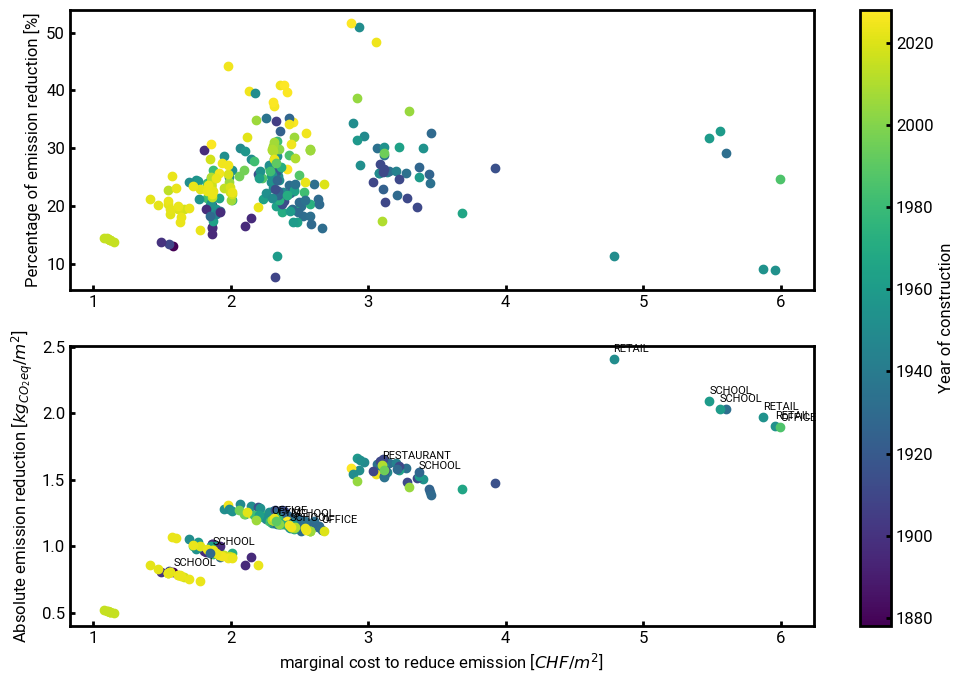

In [9]:
from matplotlib.artist import setp


fig2, axes = plt.subplots(2, 1)
for idx, ax in enumerate(axes):
    # first, plot relative emission reduction vs. marginal cost to reduce emission
    # second, plot absolute emission reduction vs. marginal cost to reduce emission
    for building_name in df_tech_cap.index.get_level_values('building').unique():
        # get the df_pareto for this building
        df_pareto = df_tech_cap.loc[building_name]
        # the first point is emission minimal, thus cost maximal, we ignore this point because it's highly unlikely to be chosen
        # last one is current status, second last one is cost minimal, thus emission maximal
        # the slope defines how hard it is to reduce emission when sliding from cost minimal to emission minimal
        x1 = df_pareto['cost'].iloc[1]
        x2 = df_pareto['cost'].iloc[-2]
        y1 = df_pareto['emission'].iloc[1]
        y2 = df_pareto['emission'].iloc[-2]
        if idx == 0: # plotting relative emission reduction
            dy = (y2-y1)/y1*100
            ax.set_ylabel('Percentage of emission reduction [%]')
        else: # idx=1, second subplot, plotting absolute emission reduction
            dy = y2-y1
            ax.set_ylabel('Absolute emission reduction [$kg_{CO_2eq}/m^2$]')

        dx = x1-x2 # absolute cost increase
        # label the points with building name next to the points
        building_year = zone_df.loc[building_name, 'YEAR']
        # building_area = zone_df.loc[building_name, 'area'] * zone_df.loc[building_name, 'floors_ag']
        building_color = colormap(year_norm(building_year))
        # find building typology 
        ax.scatter(dx, dy, label=building_name, marker='o', color=building_color) # type: ignore
        # annotate the building name next to the point
        if zone_df.loc[building_name, 'typology_1ST_USE'] not in ['SINGLE_RES', 'MULTI_RES']:
            plt.annotate(str(zone_df.loc[building_name, 'typology_1ST_USE']), (dx, dy), 
                        fontsize=8, xytext=(0, 5), textcoords='offset points', ha='left')

# share x-axis
axes[0].sharex(axes[1])
axes[1].set_xlabel('marginal cost to reduce emission [$CHF/m^2$]')
cbar2 = fig2.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=year_norm), ax=axes, orientation='vertical') # type: ignore
cbar2.set_label('Year of construction')
fig2.tight_layout()
# set title for the whole figure
# fig2.suptitle('Marginal cost to reduce emission vs. total emission reduction')


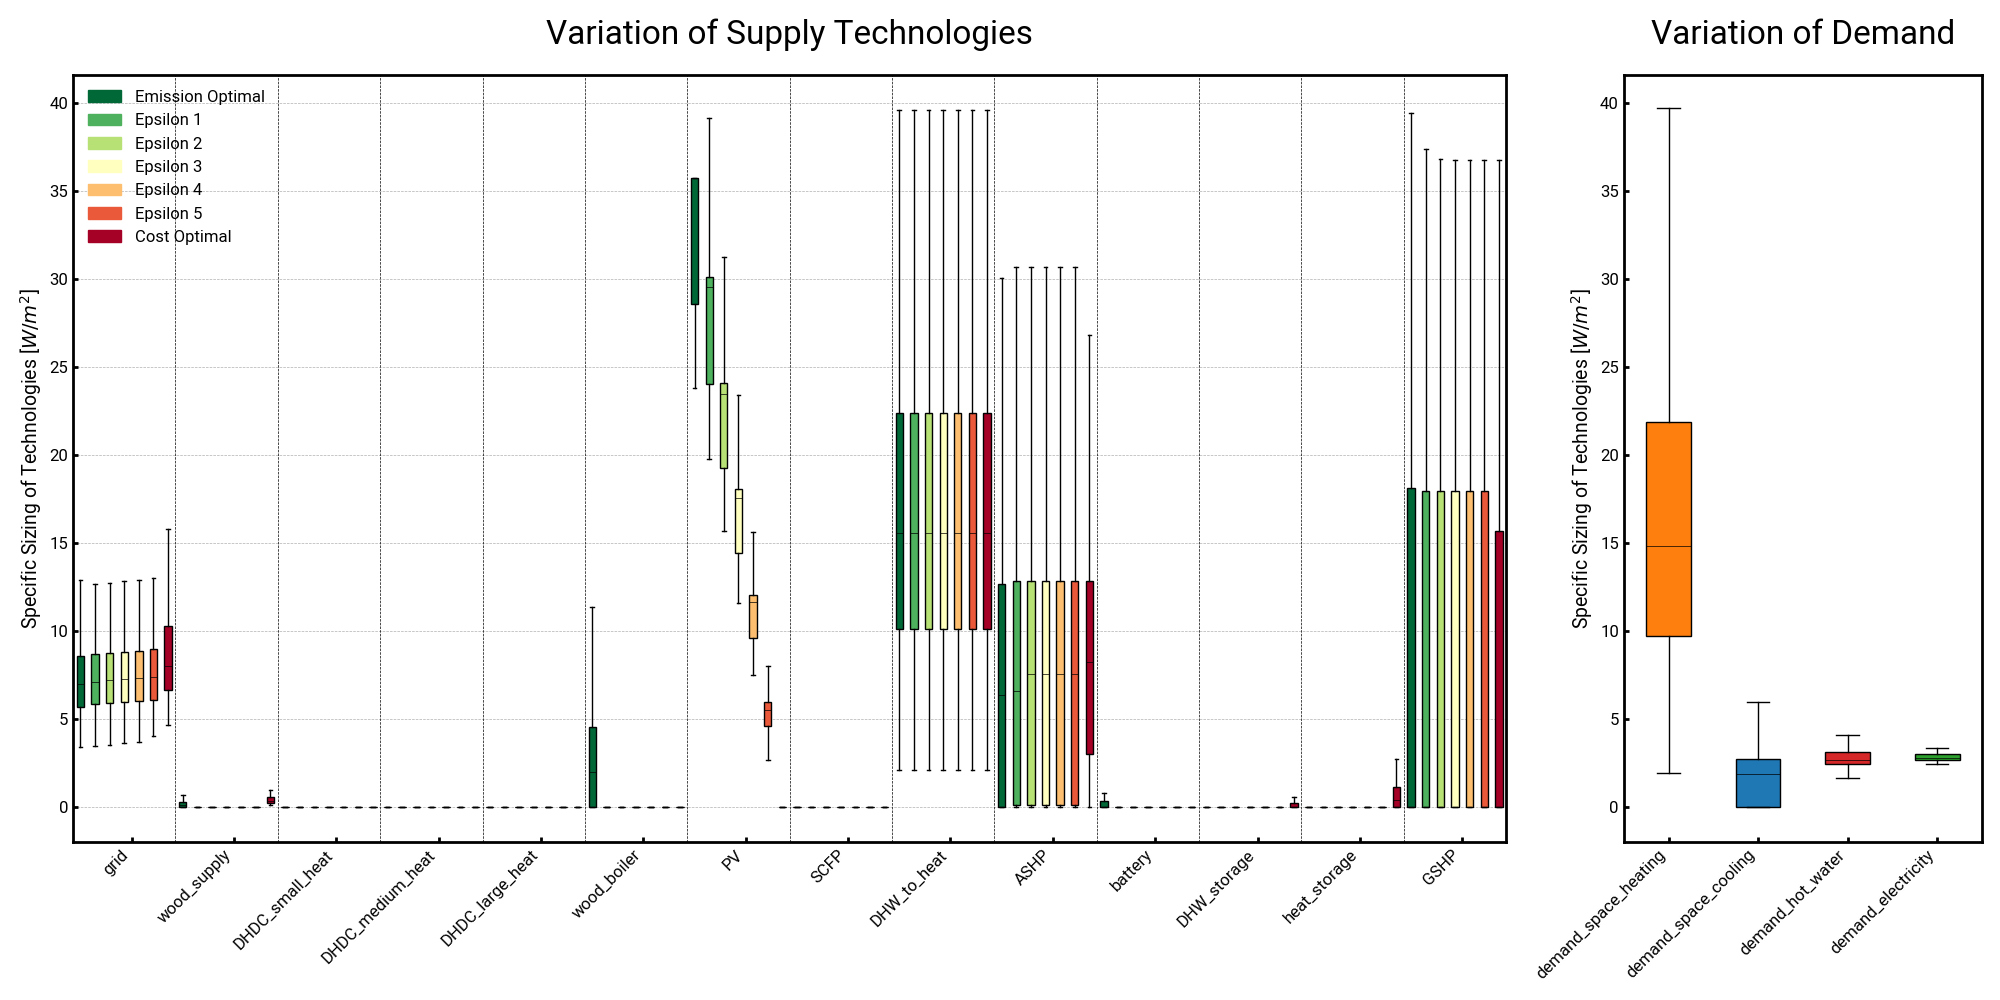

In [5]:
# Separate the demand technologies
ls_demand_name = ['demand_space_heating', 'demand_space_cooling', 'demand_hot_water', 'demand_electricity']
df_demand_tech = df_tech_cap[ls_demand_name]
df_supply_tech = df_tech_cap.drop(columns=ls_demand_name+['cost', 'emission'])
# delete the index=999 for every building, because here we only care about the epsilon cuts
df_demand_tech = df_demand_tech.drop(index=999, level=1)
df_supply_tech = df_supply_tech.drop(index=999, level=1)

# identify how many epsilon cuts are there in the dataframe in every building
n_epsilon = df_demand_tech.index.get_level_values('epsilon').nunique() # one of them is the current status

# Create a figure with two subplots side by side, with a shared y-axis and width ratio of 3:1
fig3, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [4, 1]})

# Boxplot without outliers and with a custom hatch pattern
boxprops = dict(linestyle='-', linewidth=1, color='k')  # Custom box properties
medianprops = dict(linestyle='-', linewidth=0.5, color='k')  # Custom median properties

cmap = plt.get_cmap('RdYlGn', n_epsilon) # type: ignore
cmap = cmap.reversed()
demand_colors = ['tab:orange', 'tab:blue', 'tab:red', 'tab:green']

# Create a boxplot for each supply technology and each epsilon cut
for i, tech in enumerate(df_supply_tech.columns):
    # Get the data for the current technology, each technology has nBuilding*nEpsilon rows of data
    # Reshape the data to have nEpsilon rows for each technology, each row contains the technology size across all buildings
    # for example: if there are 3 epsilon cuts and 2 buildings, the data will be [b1e1, b1e2, b1e3, b2e1, b2e2, b2e3]
    # after the reshape, the data will be [[b1e1, b1e2, b1e3], [b2e1, b2e2, b2e3]]
    tech_data = df_supply_tech[tech].values.reshape((-1, n_epsilon))  # type: ignore
    bp = axs[0].boxplot(tech_data*1000, positions=np.arange(start=i*n_epsilon, stop=i*n_epsilon+n_epsilon), # tech_data orignally in kW/m2, convert to W/m2
                        patch_artist=True, showfliers=False, boxprops=boxprops, medianprops=medianprops)
    # Fill each box with a color according to its epsilon cut
    for j, box in enumerate(bp['boxes']):
        box.set(facecolor=cmap(j))

# Create a boxplot for each demand technology, but only one box per technology
for i, tech in enumerate(df_demand_tech.columns):
    tech_data = df_demand_tech[tech].values.reshape((-1, n_epsilon)).mean(axis=1) # type: ignore
    bp = axs[1].boxplot(tech_data*1000, positions=[i], patch_artist=True, # tech_data orignally in kW/m2, convert to W/m2
                        showfliers=False, boxprops=boxprops, medianprops=medianprops, widths=0.5)  # Set position to a single value and adjust the width
    # Fill each box with a color according to its epsilon cut
    for j, box in enumerate(bp['boxes']):
        box.set(facecolor=demand_colors[i])

# Set the x-axis labels to the technology names
axs[0].set_xticks(np.arange(n_epsilon/2, len(df_supply_tech.columns)*n_epsilon, n_epsilon))  # Set x-ticks to the middle box of each technology group
axs[0].set_xticklabels(df_supply_tech.columns, rotation=45)
axs[0].set_title('Variation of Supply Technologies', fontsize=24)
axs[0].set_ylabel('Specific Sizing of Technologies [$W/m^2$]', fontsize=14)
axs[0].yaxis.grid(True, linestyle='--', linewidth=0.5)
# Draw vertical lines to separate the technologies inbetween the boundary boxes, not on the box
for i in range(n_epsilon, len(df_supply_tech.columns)*n_epsilon, n_epsilon):
    axs[0].axvline(x=i-0.5, color='k', linestyle='--', linewidth=0.5)  # Subtract 0.5 from the x position
# Create a custom legend for the epsilon cuts
ls_epsilon_cut = ['Emission Optimal'] +[f'Epsilon {i+1}' for i in range(n_epsilon-2)] + ['Cost Optimal']
legend_patches = [mpatches.Patch(color=cmap(i), label=ls_epsilon_cut[i]) for i in range(n_epsilon)]
axs[0].legend(handles=legend_patches, loc='best')

axs[1].set_xticks(range(len(df_demand_tech.columns)))  # Set x-ticks to the middle box of each technology group
axs[1].set_xticklabels(df_demand_tech.columns, rotation=45)
axs[1].set_title('Variation of Demand', fontsize=24)
axs[1].set_ylabel('Specific Sizing of Technologies [$W/m^2$]', fontsize=14)
axs[1].sharey(axs[0])
# Align the x-axis labels to the right
for ax in axs:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')
fig3.tight_layout()

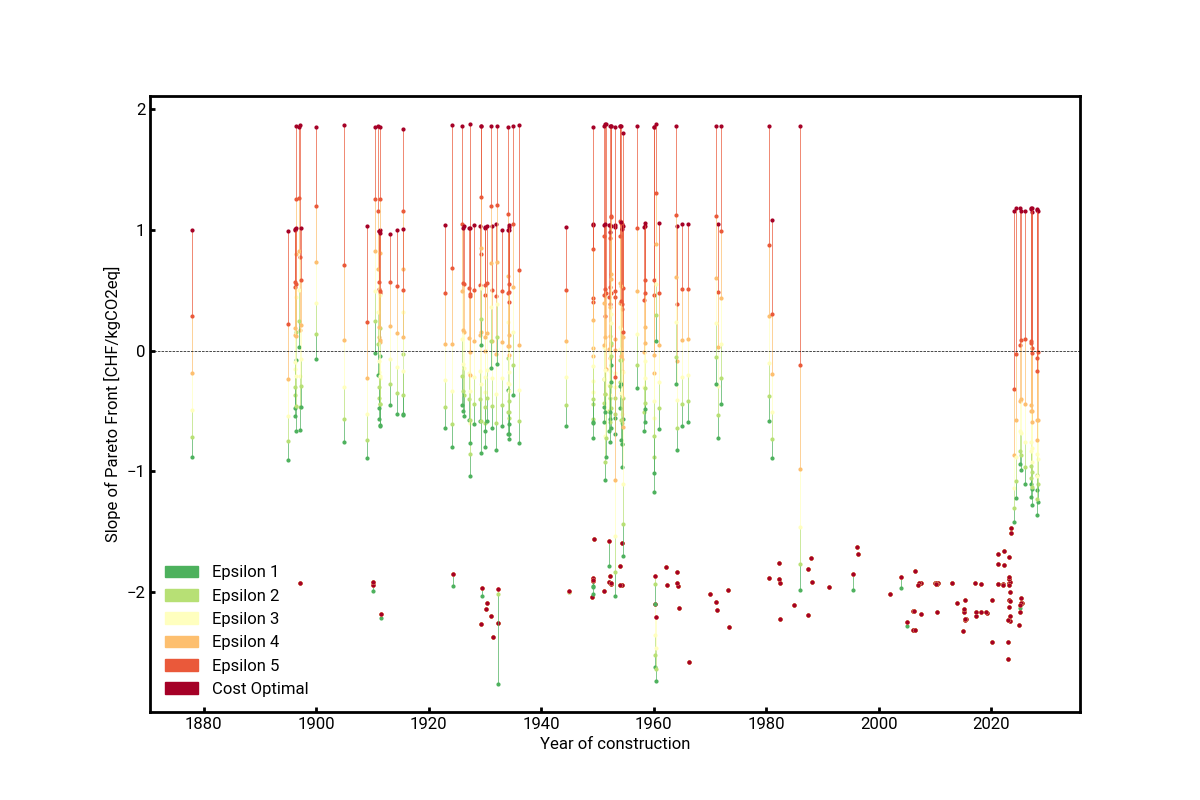

In [7]:
# in df_tech_cap, add one more column to describe the slope of current status to each point of the pareto front
# first, initialize the column slope with 0
fig4, ax = plt.subplots()
for name in df_tech_cap.index.get_level_values('building').unique():
    df_pareto = df_tech_cap.loc[name].copy()
    df_pareto = df_pareto.assign(slope=(df_pareto['cost'] - df_pareto.loc[999, 'cost']) / (df_pareto['emission'] - df_pareto.loc[999, 'emission']))
    df_pareto = df_pareto.replace([np.inf, -np.inf], np.nan).fillna(0)
    # if [999, slope] == 0, then assign it with the value of [-3, slope]
    if df_pareto['slope'].iloc[-2] - 0 < 1e-4:
        df_pareto['slope'].iloc[-2] = df_pareto['slope'].iloc[-3]
    # delete the first row of the dataframe, because it's the emission minimal, thus cost maximal, we ignore this point because it's highly unlikely to be chosen
    building_year: np.int64 = zone_df.loc[name, 'YEAR'] # type: ignore
    # if building_year is duplicated, then add a small random number to it
    if (zone_df['YEAR'] == building_year).sum() > 1:
        building_year += np.random.rand() * 0.5
    # collect the arrowhead artist for each building
    for idx, slope in enumerate(df_pareto['slope'].iloc[1:-2]):
        idx = idx+1
        # plot the line pointing from the previous slope to the current slope
        x = [building_year, building_year]
        y = [df_pareto.loc[idx, 'slope'], df_pareto.loc[idx+1, 'slope']]
        ax.plot(x, y, color=cmap(idx), linewidth=0.5)
        ax.plot(building_year, df_pareto.loc[idx, 'slope'], color=cmap(idx), marker='o', markersize=2)
    # plot the last point
    ax.plot(building_year, df_pareto['slope'].iloc[-2], color=cmap(n_epsilon-1), marker='o', markersize=2)

# add legend
ax.legend(handles=legend_patches[1:], loc='best')
ax.set_xlabel('Year of construction')
ax.set_ylabel('Slope of Pareto Front [CHF/kgCO2eq]')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')

## explore different clustering of building against pareto front
1. The goal is to compare buildings with different DH capex. If five buildings are using the same DH outlet, then every building should only share 1/5 of the DH capex. 
2. There are some buildings that belongs to the same developer. These buildings can be clustered and share the DH capex. Below I will list the buildings that belongs to the same developer.

In [ ]:
# # define the buildings with the same developer, and they will devide the DH capex equally
# # first group: B302065793, B302065787, B302065792, B302065794, B302065791, B302065789
# # second group: B162597, B162593, B162591, B162595, B162600
# # third group: B162588, B162587, B162581
# # fourth group: B302022561, B302022562
# # fifth group: B302021386, B302021387, B302021388
# # sixth group: B162416, 162422
# # seventh group: B302024523, B302024524
# # eighth group: B302030821, B302030823, B302030825, B302030820, B302030824, B302030818, B302030819
# # ninth group: B162917, B162920
# # tenth group: B162932, B162933
# # eleventh group: B162334, B162335, B162332, B162338
# # twelfth group: B162372, B162382, B162376, B162393, B162462, B162465, B162467, B162379, B162378, B162381, B162394, B162396
# # thirteenth group: B162397, B162398, B162399
# # fourteenth group: B302066076, B302066077
# # fifteenth group: B302065980, B302065981
# # sixteenth group: B302030808, B302030809, B302030810, B302030807, B302030811, B302030812, B302030813
# # seventeenth group: B302012571, B302012572, B302012573, B162602, B2365744, B2365747
# # eighteenth group: B302066212, B3020662121
# # nineteenth group: B162618, B162619, B162620, B162621, B162622, B162623
# # twentieth group: B162605, B162606
# # twenty-first group: B162473, B162475, B162477, B162479, B162481

# # create a dictionary to store the building names in each group
# dict_group = {'group1': ['B302065793', 'B302065787', 'B302065792', 'B302065794', 'B302065791', 'B302065789'],
#               'group2': ['B162597', 'B162593', 'B162591', 'B162595', 'B162600'],
#               'group3': ['B162588', 'B162587', 'B162581'],
#               'group4': ['B302022561', 'B302022562'],
#               'group5': ['B302021386', 'B302021387', 'B302021388'],
#               'group6': ['B162416', '162422'],
#               'group7': ['B302024523', 'B302024524'],
#               'group8': ['B302030821', 'B302030823', 'B302030825', 'B302030820', 'B302030824', 'B302030818', 'B302030819'],
#               'group9': ['B162917', 'B162920'],
#               'group10': ['B162932', 'B162933'],
#               'group11': ['B162334', 'B162335', 'B162332', 'B162338'],
#               'group12': ['B162372', 'B162382', 'B162376', 'B162393', 'B162462', 'B162465', 'B162467', 'B162379', 'B162378', 'B162381', 'B162394', 'B162396'],
#               'group13': ['B162397', 'B162398', 'B162399'],
#               'group14': ['B302066076', 'B302066077'],
#               'group15': ['B302065980', 'B302065981'],
#               'group16': ['B302030808', 'B302030809', 'B302030810', 'B302030807', 'B302030811', 'B302030812', 'B302030813'],
#               'group17': ['B302012571', 'B302012572', 'B302012573', 'B162602', 'B2365744', 'B2365747'],
#               'group18': ['B302066212', 'B3020662121'],
#               'group19': ['B162618', 'B162619', 'B162620', 'B162621', 'B162622', 'B162623'],
#               'group20': ['B162605', 'B162606'],
#               'group21': ['B162473', 'B162475', 'B162477', 'B162479', 'B162481']
#               }